### Initialization

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from astropy import units
from slsim.lens_pop import LensPop
import numpy as np
from astropy.table import Column, Table, hstack
import corner
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from distfit import distfit
from matplotlib.ticker import NullFormatter
import seaborn as sns

In [2]:
# Plotting functions
def plot(x, y, x_label, y_label, title, color, legend, label):
    plt.plot(x, y, color=color, label=label)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize='15')
    if legend:
        plt.legend(fontsize=15)

def semilog(x, y, x_label, y_label, title, color, legend, label):
    plt.semilogy(x, y, color=color, label=label)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize='15')
    if legend:
        plt.legend(fontsize=15)

def hist(x, x_label, y_label, title, legend, label, bins, color):
    plt.hist(x, bins=bins, label=label, color=color)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize='15')
    if legend:
        plt.legend(fontsize=15)

def scatter(x, y, x_label, y_label, title, legend, label, color):
    plt.scatter(x, y, label=label, color=color, s=10)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize='15')
    if legend:
        plt.legend(fontsize=15)

## Supernovae Ia Population Overview
Within this overview notebook, we illustrate the process of SNe Ia population implementation and analyze the population distribution


1. Number density calculation (SNIaRate Class)

2. Lightcone integration (SNeLightcone Class)

3. Host galaxy matching (SupernovaeHostMatch Class)

4. Host galaxy offset distribution and selection (Requires download of Wang et al. 2013 SNe Ia sample from the resources section of the following link: https://www.science.org/doi/10.1126/science.1231502)

5. Analyzing the population  
(Requires download of the "SALT3.NIR_WAVEEXT" data folder
from the following link: https://github.com/LSST-strong-lensing/data_public/tree/main/sncosmo_sn_models)

6. Imaging the population


## Number Density Calculation

### Initialize the SNIaRate Class

In [3]:
from slsim.Sources.Supernovae.supernovae_pop import SNIaRate

# Define a cosmology
cosmo = FlatLambdaCDM(70, 0.3)

# Initialize the class
sne_rate = SNIaRate(cosmo, 10)

### Plots

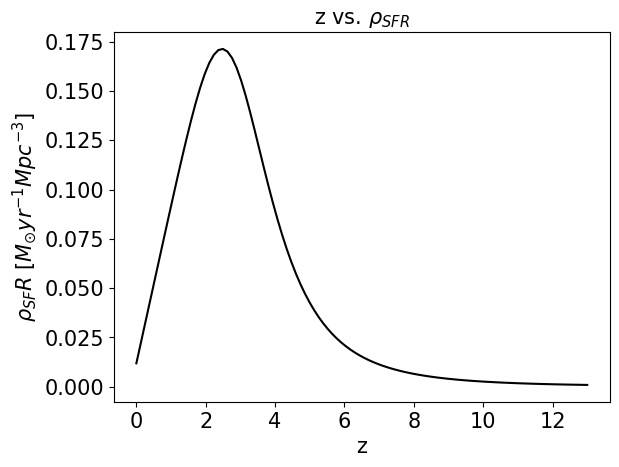

In [4]:
from slsim.Sources.Supernovae.supernovae_pop import calculate_star_formation_rate

# Define array of redshifts
z_array = np.linspace(0, 13, 100)
rate_list = []

# Calculate star formation rate given redshift using the function 'calculate_star_formation_rate'
for i in np.arange(100):
    rate_list.append(calculate_star_formation_rate(z_array[i]))

# Plot star formation rate as a function of redshift
plot(z_array, rate_list, 'z', r'$\rho_{SF}R$ $[ M_{\odot} yr^{-1}Mpc^{-3}]$', "z vs. " r'$\rho_{SFR}$', 'black', False, 'n/a')

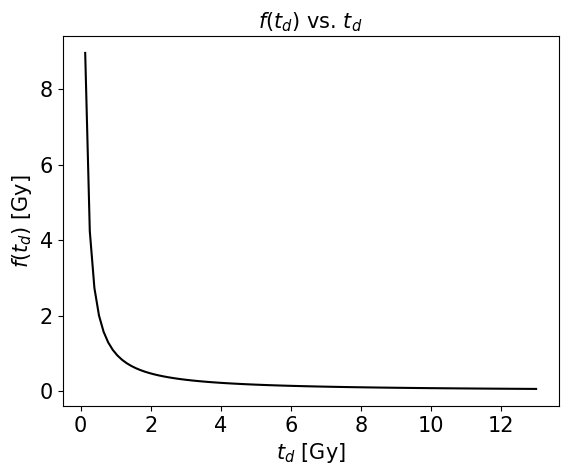

In [5]:
from slsim.Sources.Supernovae.supernovae_pop import delay_time_distribution

# Define array of time delays
t_d_array = np.linspace(0, 13, 100)
dist_list = []

# Calculate time delay distribution given time delay using the function 'delay_time_distribution'
for i in np.arange(100):
    dist_list.append(delay_time_distribution(t_d_array[i]))

# Plot time delay distribution as a function of time delay
plot(t_d_array, dist_list, r'$t_{d}$ [Gy]', r'$f(t_{d})$ [Gy]', "$f(t_{d})$ vs. $t_{d}$", 'black', False, 'n/a')

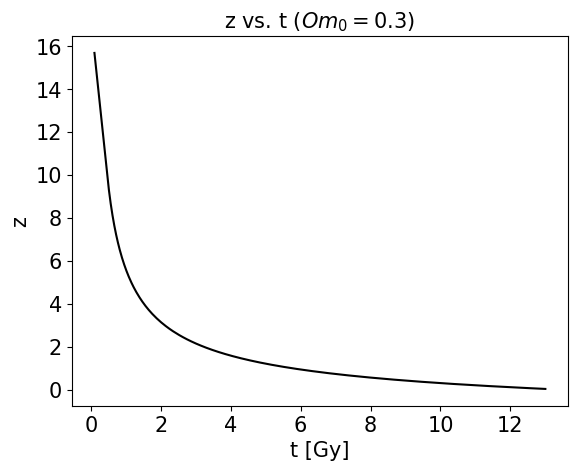

In [6]:
# Define array of times
t_array = np.linspace(0.1, 13, 1000)

z_list=[]

# Calculate redshift given time using the class function 'z_from_t'
for i in np.arange(1000):
    z_list.append(sne_rate.z_from_time(t_array[i]))

# Plot redshift as a function of time
plot(t_array, z_list, 't [Gy]', 'z', "z vs. t $(Om_{0} = 0.3)$", 'black', False, r'$H_{0}$=70')

(1e-05, 0.001)

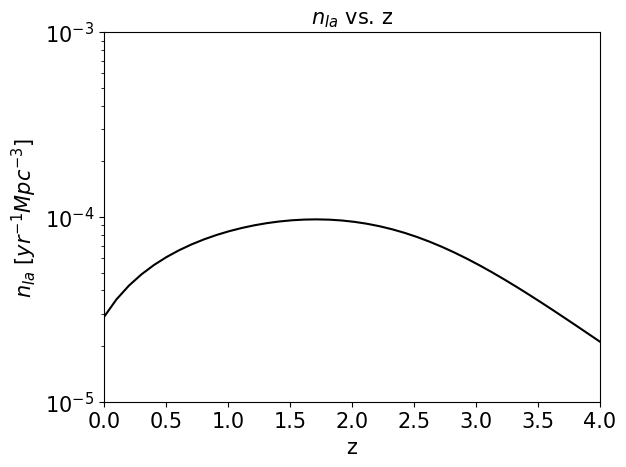

In [7]:
# Define array of redshifts
z_array = np.linspace(0, 10, 100)

# Define "little" h
h = cosmo.H(0).to_value() / 100

# Calculate density given redshift using the class function 'calculate_SNIa_rate'
density_list = sne_rate.calculate_SNIa_rate(z_array) * h

# Plot number density vs. redshift (Replicating Fig. 2 - Oguri and Marshall 2010)
semilog(z_array, density_list, 'z', r'$n_{Ia}$ $[yr^{-1}Mpc^{-3}]$', "$n_{Ia}$ vs. z", 'black', False, r'$H_{0}$=70')
plt.xlim(0,4)
plt.ylim(10e-6,10e-4)

## Lightcone Integration

(52484,)


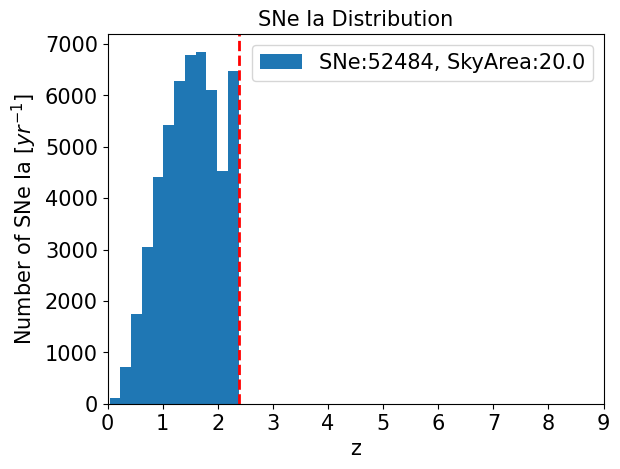

In [8]:
from slsim.Sources.Supernovae.supernovae_lightcone import SNeLightcone

# Define a cosmology
cosmo = FlatLambdaCDM(70, 0.3)

# Define redshift range of the lightcone (at the moment, i-band lightcurve upper limit = 2.379)
redshifts = np.linspace(0, 2.379, 50)

# Define sky area of the lightcone
sky_area = Quantity(value=20, unit="deg2")

# Consider noise in lightcone integration
noise = True

# Define a time interval of the lightcone
time_interval = 1*units.year

# Intialize lightcone class
sne_lightcone = SNeLightcone(cosmo, redshifts, sky_area, noise, time_interval)

# Generate supernovae catalog within the initialized lightcone using the class function 'supernovae_sample'
lightcone_array = sne_lightcone.supernovae_sample()

# Plot histogram of the number of obtained supernovae within the lightcone as a function of redshift
label = "SNe:{}, SkyArea:{}".format(len(lightcone_array), sky_area.value)
hist(lightcone_array, 'z', 'Number of SNe Ia [$yr^{-1}$]', 'SNe Ia Distribution', True, label, 12, None)
plt.xlim(0,9)

# Include i-band lightcurve cutoff line on the plot for clarity
plt.axvline(x=2.379, color='red', linestyle='--', linewidth=2)

print(np.shape(lightcone_array))

## Host Galaxy Matching

### Supernovae Catalog Generation

In [9]:
# Define a cosmology
cosmo = FlatLambdaCDM(70, 0.3)

# Define sky area
sky_area = Quantity(value=1, unit="deg2")

# Initialize lightcone class
sne_lightcone = SNeLightcone(
            cosmo=cosmo,
            redshifts=np.linspace(0, 2.379, 50),
            sky_area=sky_area,
            noise=True,
            time_interval=1 * units.year,
        )

# Generate supernovae catalog within the initialized lightcone using the class function 'supernovae_sample'
supernovae_catalog = sne_lightcone.supernovae_sample()

### Galaxy Catalog Generation

In [10]:
from slsim.Sources.galaxy_catalog import GalaxyCatalog

# Define sky area
sky_area = Quantity(value=1, unit="deg2")

# Initialize galaxy catalog class
galaxy_catalog = GalaxyCatalog(
                cosmo=cosmo,
                skypy_config=None,
                sky_area= sky_area
            )

# Generate galaxy catalog within the using the class function 'galaxy_catalog'
galaxy_catalog = galaxy_catalog.galaxy_catalog()

### Catalog Matching

In [11]:
from slsim.Sources.supernovae_host_match import SupernovaeHostMatch

# Intialize SNe Ia host galaxy matching class
sne_match = SupernovaeHostMatch(supernovae_catalog, galaxy_catalog)

# Generate a catalog of SNe Ia matched with corresponding host galaxies using class function 'match'
matched_catalog = sne_match.match()

### Plot

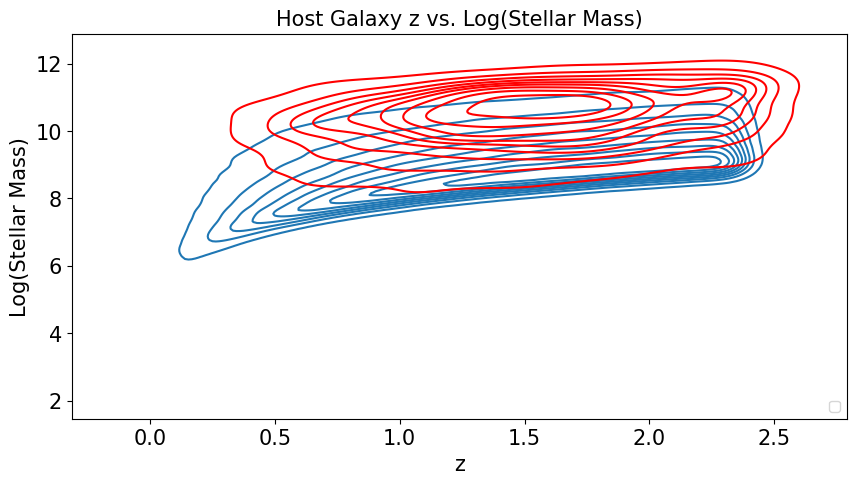

In [17]:
plt.figure(figsize=(10, 5))

# Plot log host galaxy stellar mass vs. redshift scatter plot
#scatter(galaxy_catalog['z'], np.log10(galaxy_catalog['stellar_mass']), 'z', 'Log(Stellar Mass)', 'Host Galaxy z vs. Log(Stellar Mass)', True, 'All Candidates', None)
#scatter(matched_catalog['z'], np.log10(matched_catalog['stellar_mass']), 'z', 'Log(Stellar Mass)', 'Host Galaxy z vs. Log(Stellar Mass)', True, 'Selected Hosts', 'red')

# Plot log host galaxy stellar mass vs. redshift contour plot
sns.kdeplot(x=galaxy_catalog['z'], y=np.log10(galaxy_catalog['stellar_mass']), color=None, label='', legend=True)
sns.kdeplot(x=matched_catalog['z'], y=np.log10(matched_catalog['stellar_mass']), color="red", label='Selected Hosts', legend=True)
plt.title('Host Galaxy z vs. Log(Stellar Mass)', fontsize=15)
plt.xlabel('z', fontsize=15)
plt.ylabel('Log(Stellar Mass)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', labels=['All Candidates', 'Selected Hosts'])

## Host Galaxy Offset Distribution

In [14]:
# Import Wang et al. 2013 SNe Ia dataset
file_path = 'C:/Users/Carly/Downloads/offset_data.csv' # '....../Downloads/data.csv'

data = pd.read_csv(file_path, delimiter = "\t")

# Select the data in the offset ratio column
data = np.array(data['R_sn/R_gal'])

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [lognorm] [0.00 sec] [RSS: 0.0914444] [loc=-0.028 scale=0.451]
[distfit] >INFO> [lognorm] [0.00 sec] [RSS: 0.0914444] [loc=-0.028 scale=0.451]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Lognorm(loc:-0.028455, scale:0.450885)


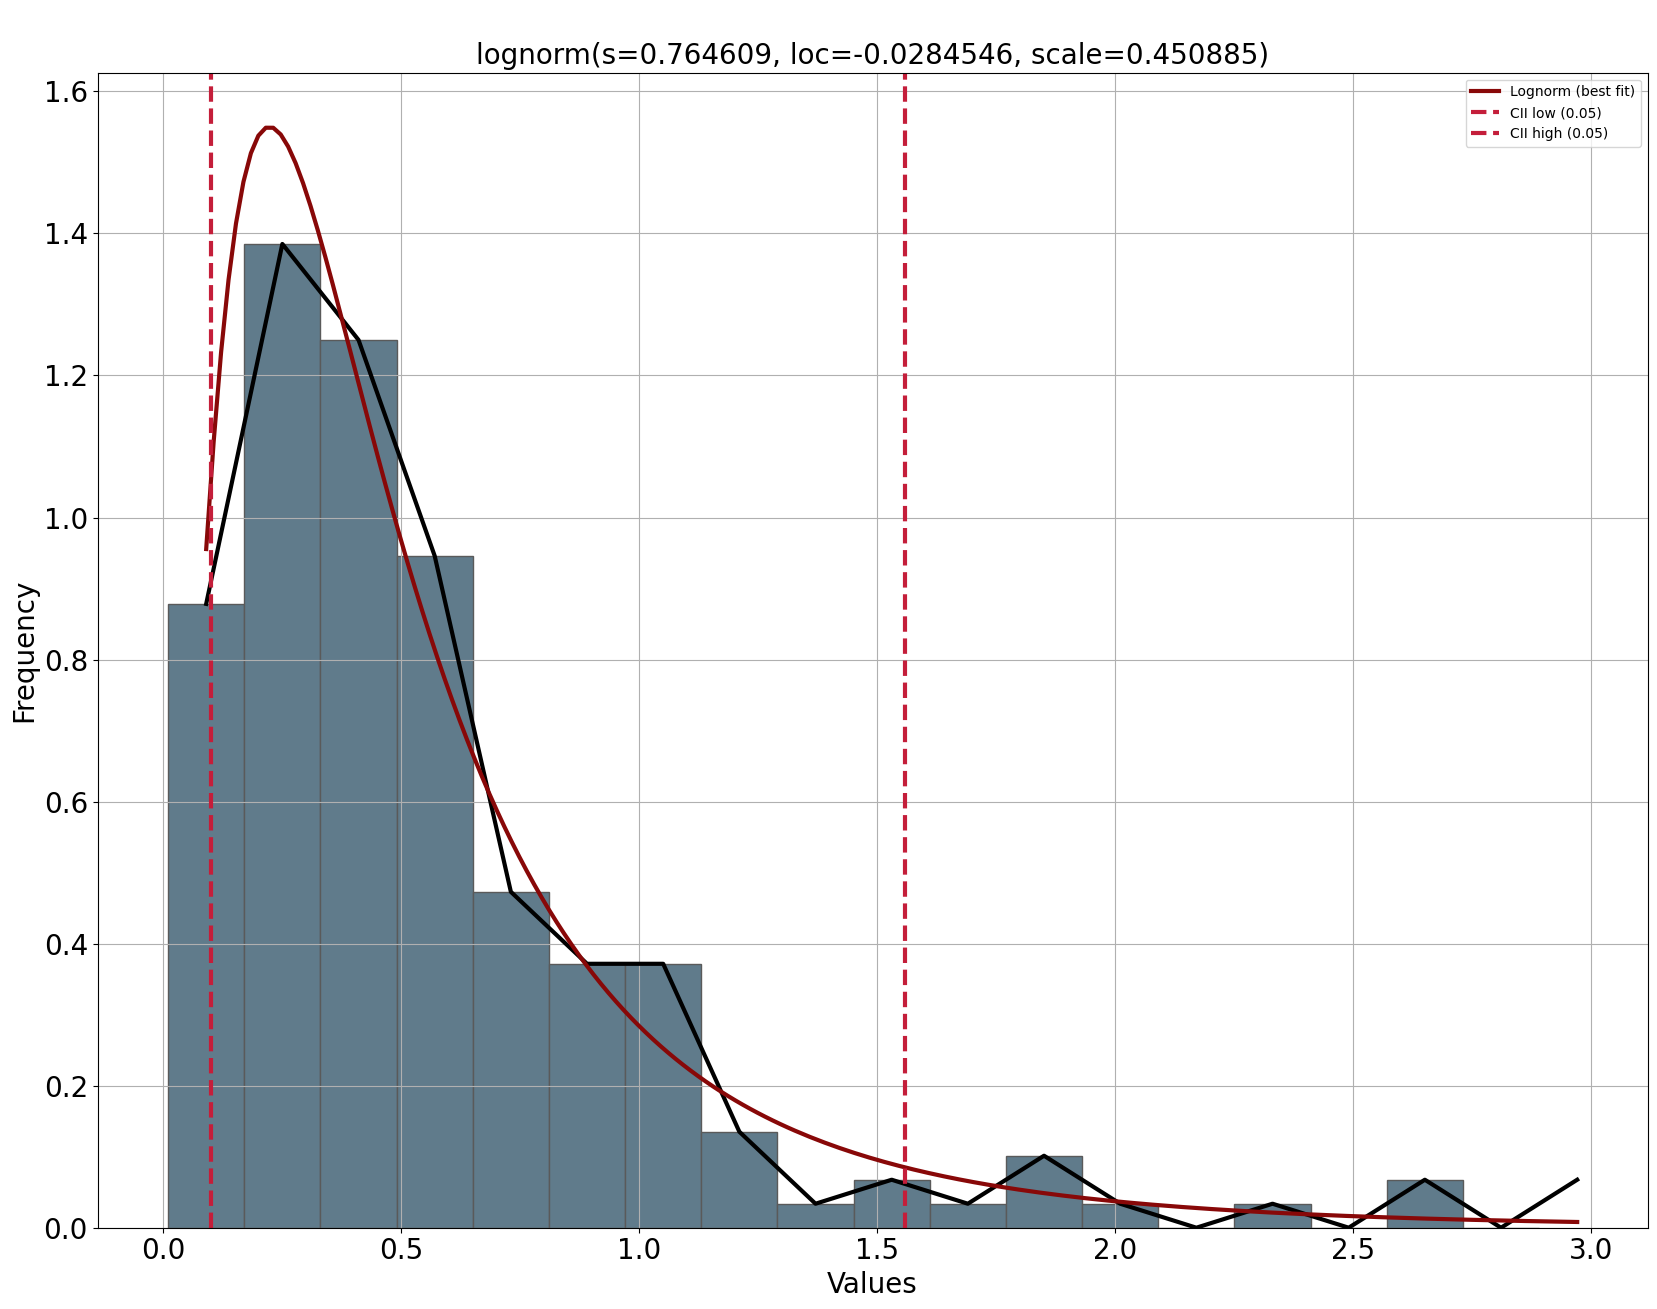

In [15]:
# Determine the parameters for a lognormal distribution fitted to the offset data
dfit = distfit(distr='lognorm')
dfit.fit_transform(data)
fig, ax = dfit.plot(chart='pdf', fontsize='20')

(array([ 85., 138., 108.,  52.,  41.,  30.,   9.,  16.,   3.,   4.,   6.,
          1.,   2.,   0.,   2.]),
 array([-0.00379923,  0.18825183,  0.38030289,  0.57235395,  0.764405  ,
         0.95645606,  1.14850712,  1.34055818,  1.53260924,  1.7246603 ,
         1.91671136,  2.10876242,  2.30081348,  2.49286454,  2.6849156 ,
         2.87696666]),
 <BarContainer object of 15 artists>)

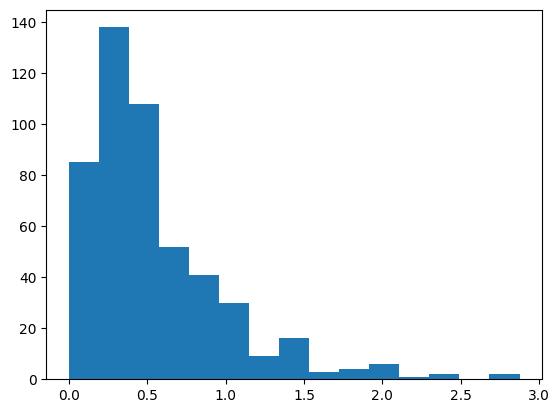

In [18]:
# Calculate a sample distribution of offset ratios drawn from the lognorm distribution
offsets = list(stats.lognorm.rvs(0.764609, loc=-0.0284546, scale=0.450885, size=500))

# Limit offset ratios to 3 or less
offsets = [offset for offset in offsets if offset < 3]

# Plot a histogram of offset ratios
plt.hist(offsets, bins=15)

## Host Galaxy Offset Selection

### Calculate Offsets

In [19]:
from slsim.Sources.SupernovaeCatalog.supernovae_sample import supernovae_host_galaxy_offset

# Calculate offsets for the matched catalog using the function 'supernovae_host_galaxy_offset'
x_offset, y_offset, e1, e2 = supernovae_host_galaxy_offset(matched_catalog)

### Plot

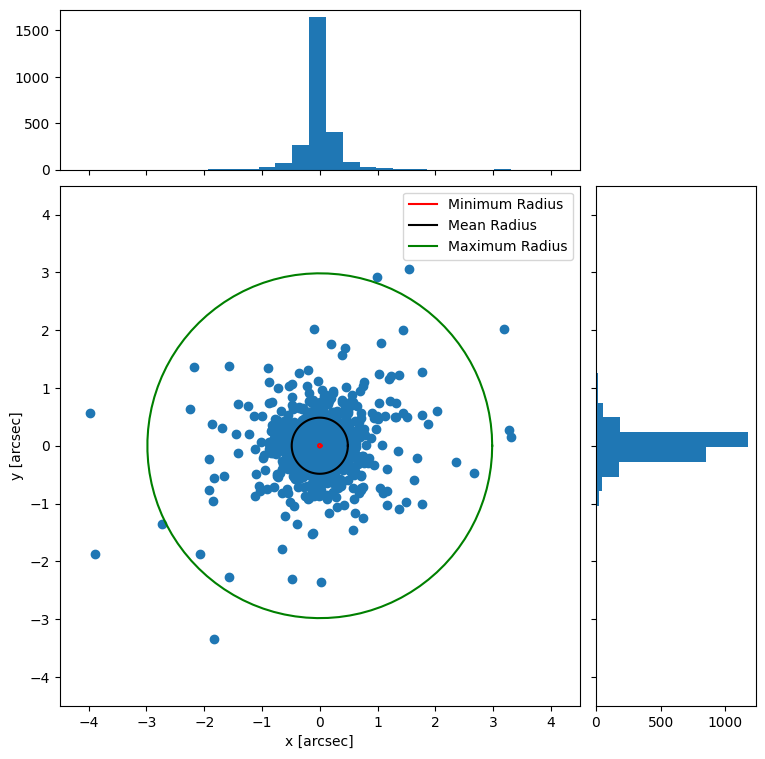

In [20]:
x = x_offset
y = y_offset

nullfmt = NullFormatter()

# Set axes sizes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# Set figure sizes and types
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# Plot the x and y offsets in a scatter plot
axScatter.scatter(x, y)

# Determine and set axes limits
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-4.5, 4.5))
axScatter.set_ylim((-4.5, 4.5))

# Set the number of bins in the outer histograms
bins = np.arange(-4.5, 4.5 + binwidth, binwidth)
axHistx.hist(x, bins=25)
axHisty.hist(y, bins=25, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

# Calculate minimum, maximum, and mean host galaxy radii
theta = np.linspace(0, 2*np.pi, 100)
r_mean = np.rad2deg(np.mean(matched_catalog['angular_size'])) * units.deg
r_min = np.rad2deg(np.min(matched_catalog['angular_size'])) * units.deg
r_max = np.rad2deg(np.max(matched_catalog['angular_size'])) * units.deg
r_mean = r_mean.to(units.arcsec)
r_min = r_min.to(units.arcsec)
r_max = r_max.to(units.arcsec)

# Plot the radii
x = r_min*np.cos(theta)
y = r_min*np.sin(theta)
axScatter.plot(x,y, color='red', label="Minimum Radius")

x = r_mean*np.cos(theta)
y = r_mean*np.sin(theta)
axScatter.plot(x,y, color='black', label="Mean Radius")

x = r_max*np.cos(theta)
y = r_max*np.sin(theta)
axScatter.plot(x,y, color='green', label="Maximum Radius")

axScatter.set_xlabel('x [arcsec]')
axScatter.set_ylabel('y [arcsec]')
axScatter.legend()
plt.show()

## Analyzing the Population

### Generate Lensed Population (Point Source)

In [27]:
# Define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Define sky area scaling
sky_area = Quantity(value=30, unit="deg2")

# Define source and deflector sky areas
source_sky_area = Quantity(value=1, unit="deg2")
deflector_sky_area = Quantity(value=1, unit="deg2")

# Define limits in the intrinsic deflector and source population (in addition to the
# skypy config file)
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.379}
kwargs_source_cut = {}

# Create a point source lens population with 'LensPop'
modeldir = "/Users/Carly/Downloads/SALT3.NIR_WAVEEXT/" #....../Downloads/SALT3.NIR_WAVEEXT/
supernova_lens_pop_ps = LensPop(
    deflector_type="all-galaxies",  # Type of the deflector (elliptical or all-galaxies)
    source_type="supernovae",  # Keyword for source type (galaxies, quasar, 
    #quasar_plus_galaxies, or supernovae_plus_galaxies)
    kwargs_deflector_cut=kwargs_deflector_cut,  # Cuts to apply to deflector
    kwargs_source_cut=kwargs_source_cut,  # Cuts to apply to source
    variability_model="light_curve",  # Keyword for the variability model
    kwargs_variability={"supernovae_lightcurve", "i"},  # Specify keywords for
    # lightcurve with band type 'i'
    sn_type="Ia",  # Supernovae type.
    sn_absolute_mag_band="bessellb",  # Band used to normalize to absolute magnitude
    sn_absolute_zpsys="ab",  # Magnitude system (Optional, AB or Vega)
    kwargs_mass2light=None,  # Mass-to-light relation for the deflector galaxy
    skypy_config=None,  # Sky configuration for the simulation (If None, lsst-like
    # configuration will be used)
    sky_area=sky_area,  # Scaled sky area for the simulation
    source_sky_area = source_sky_area,
    deflector_sky_area = deflector_sky_area,
    cosmo=cosmo,  # Astropy cosmology
    source_light_profile="double_sersic",  # Light profile for the source galaxy
    catalog_type=None,  # Catalog type (None or scotch)
    sn_modeldir= modeldir,  # Selected model's directory
    lightcurve_time=np.linspace(-50, 100, 1000)  # Array of light curve observation time

)

[distfit] >INFO> Setting cosmology


[distfit] >INFO> Calling FlatLambdaCDM
[distfit] >INFO> Generating z_range
[distfit] >INFO> Calling arange
[distfit] >INFO> Generating M_star_blue
[distfit] >INFO> Calling Linear1D
[distfit] >INFO> Generating phi_star_blue
[distfit] >INFO> Calling Exponential1D
[distfit] >INFO> Generating M_star_red
[distfit] >INFO> Calling Linear1D
[distfit] >INFO> Generating phi_star_red
[distfit] >INFO> Calling Exponential1D
[distfit] >INFO> Generating magnitude_limit
[distfit] >INFO> Generating fsky
[distfit] >INFO> Generating filters
[distfit] >INFO> Generating blue
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating red1
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating red2
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating red
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating blue.z, M
[distfit] >INFO> Calling schechter_lf
[distfit] >INFO> Generating red1.z1, M1
[distfit] >INFO> Calling schechter_lf
[distfit] >INFO> Generating red2.z2, M2
[distfit] >INFO> Callin

In [28]:
# Print the number of resulting deflectors and sources
supernova_lens_pop_ps.deflector_number, supernova_lens_pop_ps.source_number

(34069350, 76560)

In [29]:
# Specify cuts to the population
kwargs_lens_cuts = {}

# Determine the lensed population using 'draw_population'
supernova_lens_population_ps = supernova_lens_pop_ps.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts,
    speed_factor=10000)

# Print the number of resulting lensed supernovae in the population
len(supernova_lens_population_ps)

128

### Corner Plot

In [33]:
from slsim.lens import image_separation_from_positions

# Define parameter labels
lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
    r"$t_{\rm d}$",
    "m",
    r"$im_{\rm sep}$"
]

# Calculate parameters for each lens
for ps_lens in supernova_lens_population_ps:
    vel_disp = ps_lens.deflector_velocity_dispersion()
    m_star = ps_lens.deflector_stellar_mass()
    theta_e = ps_lens.einstein_radius
    zl = ps_lens.deflector_redshift
    zs = ps_lens.source_redshift
    source_mag = min(ps_lens.point_source_magnitude(band="i", lensed=True))
    deflector_mag = ps_lens.deflector_magnitude(band="i")
    time_delay = ps_lens.point_source_arrival_times()
    magnification = ps_lens.point_source_magnification()
    image_sep = image_separation_from_positions(ps_lens.point_source_image_positions())
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag, time_delay[0], magnification[0], image_sep]
    )

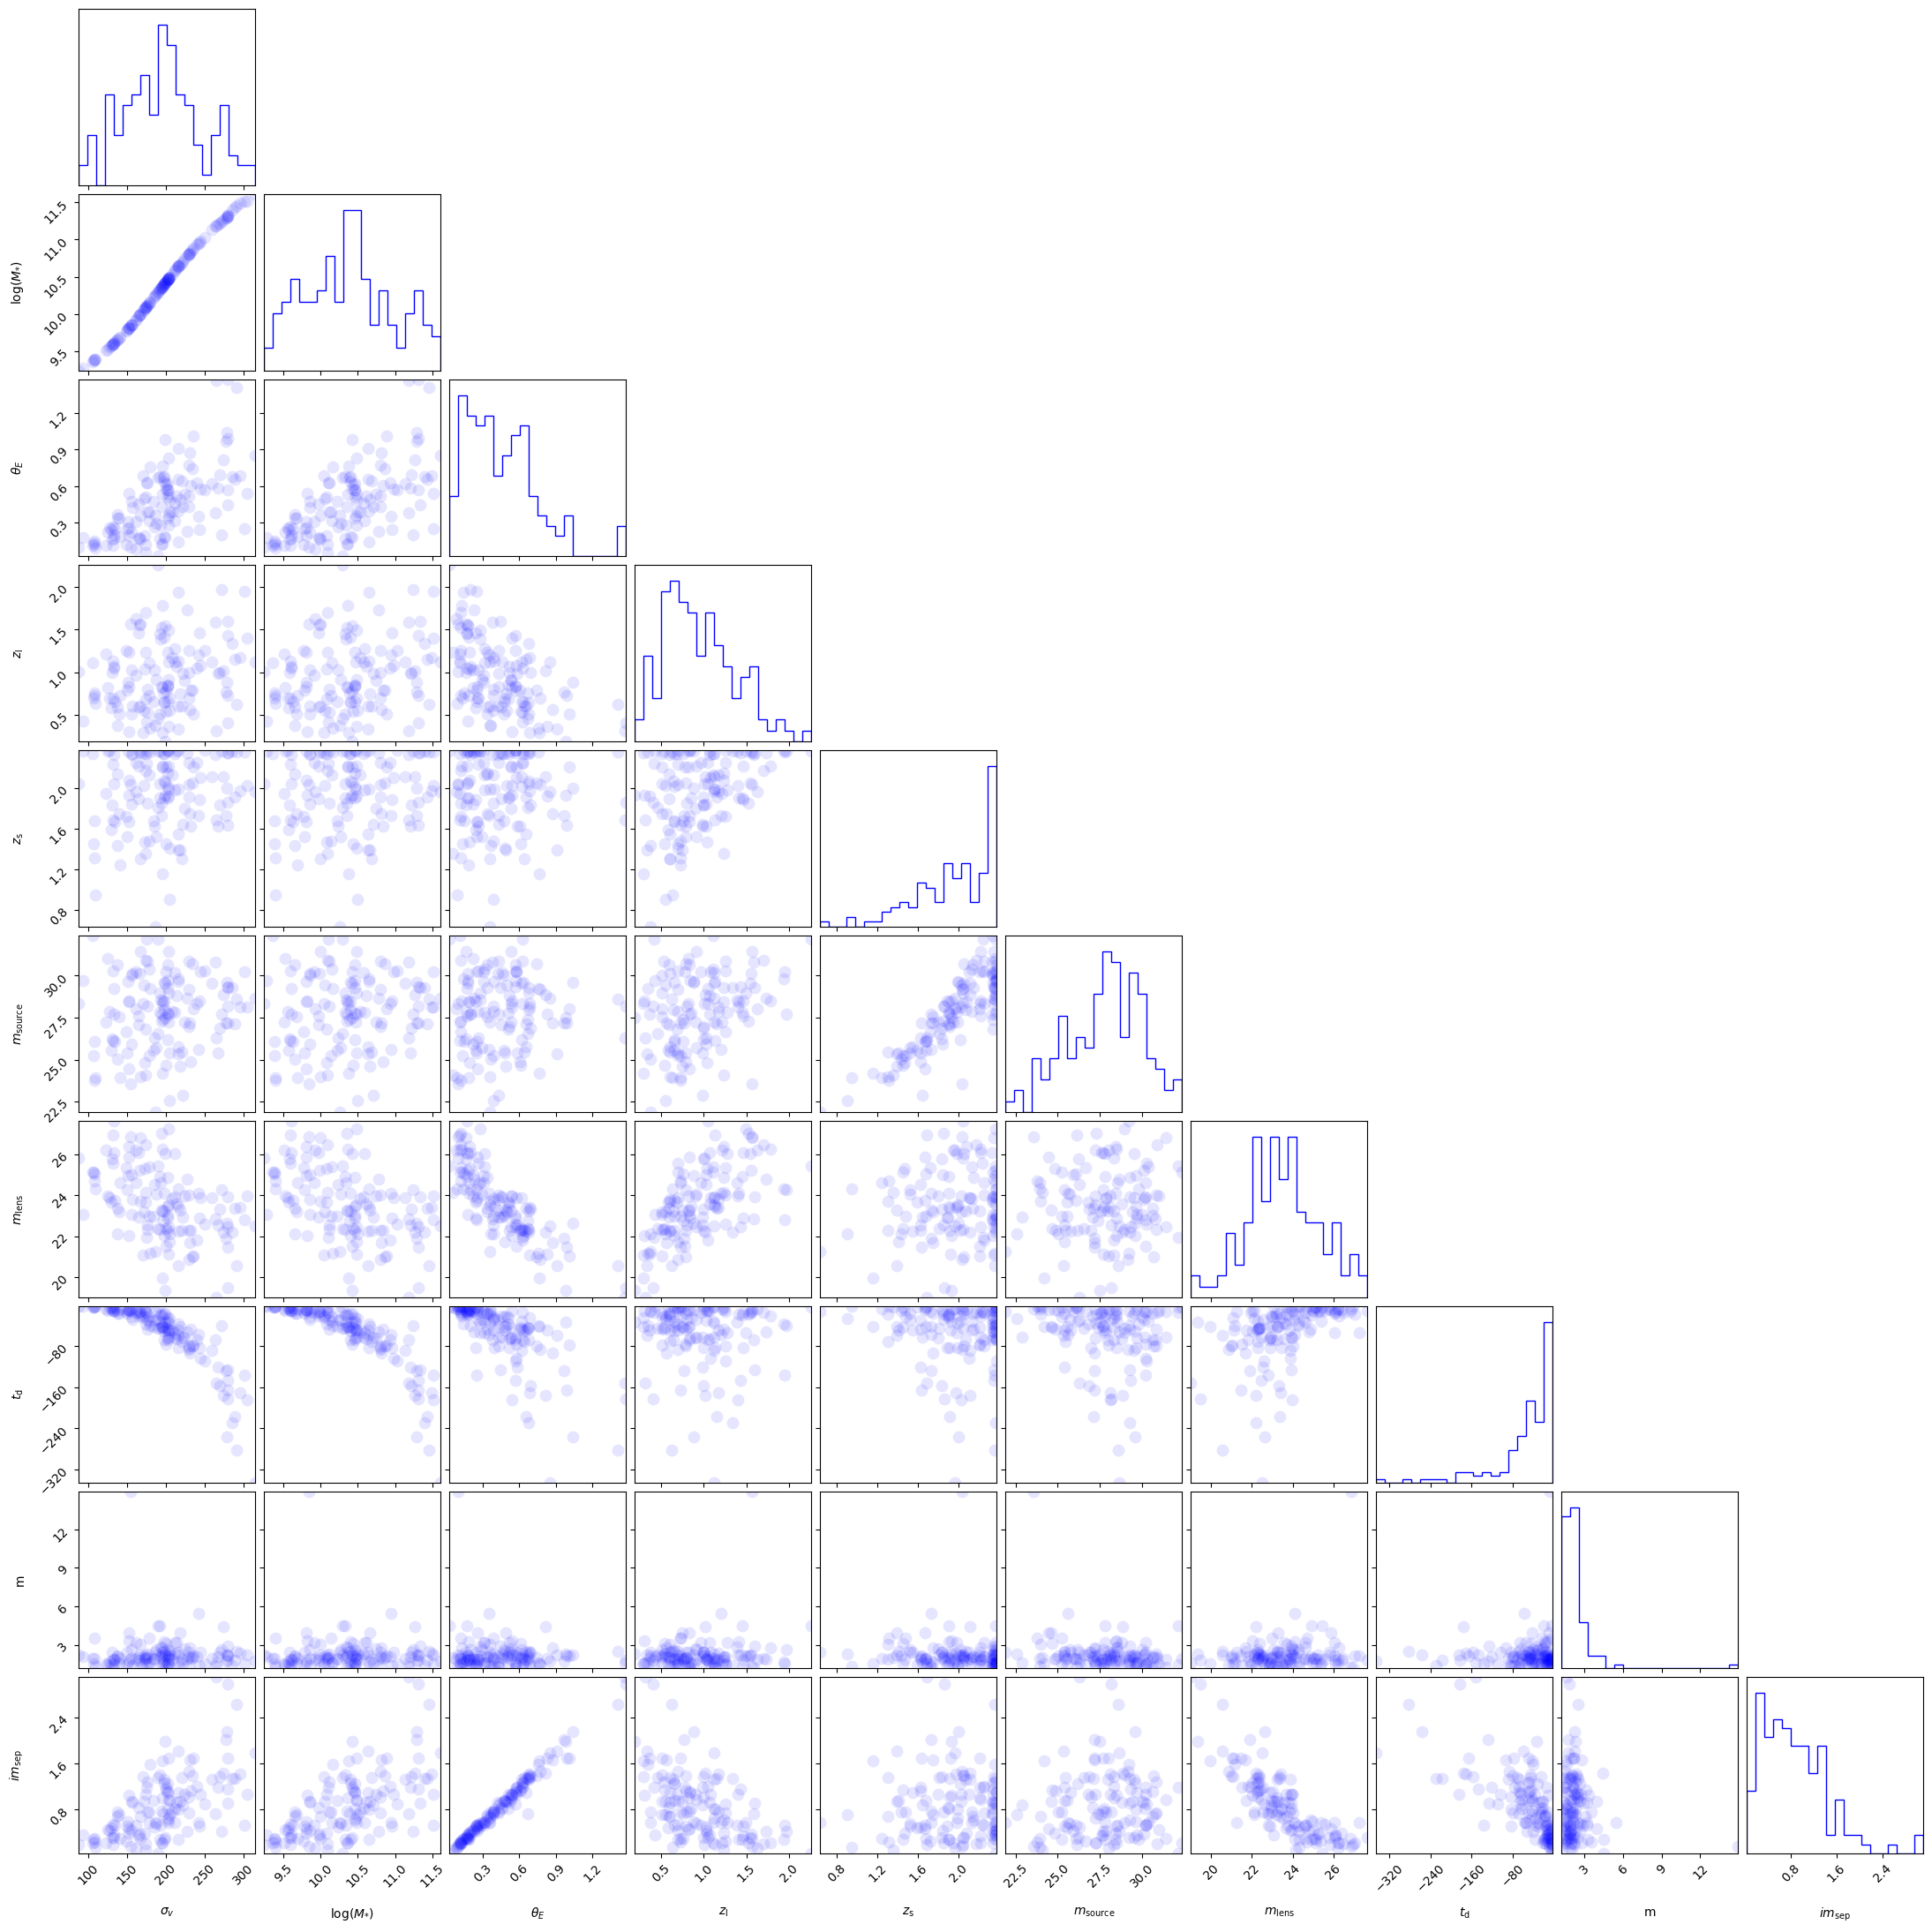

In [35]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 10}
}

# Create corner plot with the calculated parameters for the lensed population
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()

### Redshift Distribution Plot

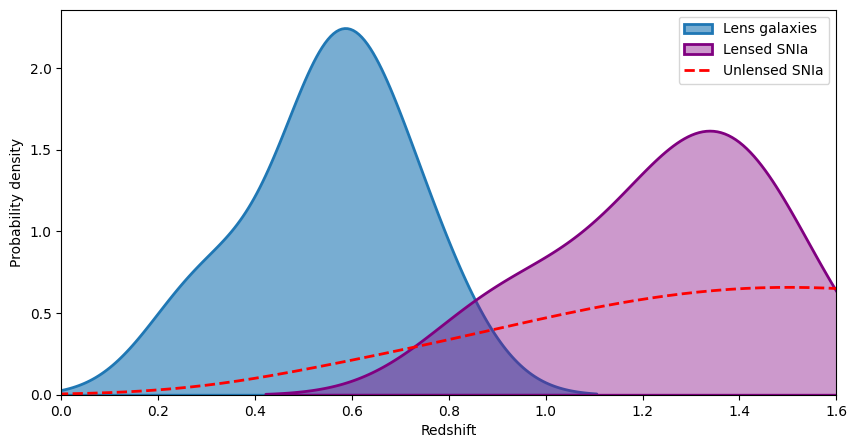

<Figure size 1000x500 with 0 Axes>

In [61]:
from slsim.lens import image_separation_from_positions

# Calculate parameters and apply selection criteria
redshift_dist = []
for ps_lens in supernova_lens_population_ps:
    zl = ps_lens.deflector_redshift
    zs = ps_lens.source_redshift
    image_sep = image_separation_from_positions(ps_lens.point_source_image_positions())
    source_mag = ps_lens.point_source_magnitude(band="i", lensed=True)
    
    # Fig.2 - Arendse et al. 2024 redshift cut
    if(zl < 1.5 and zs < 1.5):

        # Multiply imaged criteria
        if len(source_mag) > 1:

            # Source magnitude cut
            if(min(source_mag) < 25):
                if len(source_mag) == 2:
                    flux_ratio = 10**((source_mag[1]-source_mag[0])/(-2.5))
                    # SNe flux ratio criteria for doubly lensed sources (0.1 < ratio < 10)
                    if(flux_ratio > 0.1 and flux_ratio < 10):
                        # Image separation criteria (0.1 < sep < 4)
                        if(image_sep > 0.5 and image_sep < 4):
                            redshift_dist.append(
                                [zl, zs]
                            )
                else:
                    # Image separation criteria (0.1 < sep < 4)
                    if(image_sep > 0.5 and image_sep < 4):
                            redshift_dist.append(
                                [zl, zs]
                            )
        
        # Magnification criteria
        else:
            if(min(source_mag) < 25):
                redshift_dist.append([zl, zs])


# Find unlensed SNe distribution as the difference between total SNe and lensed SNe
from collections import Counter
source_list = list(supernova_lens_pop_ps._sources._point_source_select.columns[0])

size = supernova_lens_pop_ps.source_number - len([sublist[1] for sublist in redshift_dist])
total_SNe = np.random.choice(source_list, size=size, replace=True)

unlensed_SNe = list((Counter(total_SNe) - Counter([sublist[1] for sublist in redshift_dist])).elements())

# Redshift PDF Plotting 
# Replicating Fig. 2 - Arendse et al. 2024 (Without z < 1.5 redshift cut)
import seaborn as sns
plt.figure(figsize=(10, 5))

# Plot deflector population
sns.kdeplot([sublist[0] for sublist in redshift_dist], fill=True, label='Lens galaxies', alpha=0.6, linewidth=2)

# Plot source population
sns.kdeplot([sublist[1] for sublist in redshift_dist], fill=True, label='Lensed SNIa', color='purple', alpha=0.4, linewidth=2)

# Plot unlensed SN Ia population
sns.kdeplot(unlensed_SNe, fill=False, linestyle='--', label='Unlensed SNIa', color='red', linewidth=2, bw_adjust=3)

plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.grid(False)
plt.xlim(0, 1.6)
plt.figure(figsize=(10, 5))
plt.show()

## Imaging the Population

### Generate Lensed Population (Extended Source)

In [64]:
# Define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Define sky area scaling
sky_area = Quantity(value=10, unit="deg2")

# Define source and deflector sky areas
source_sky_area = Quantity(value=1, unit="deg2")
deflector_sky_area = Quantity(value=1, unit="deg2")

# Define limits in the intrinsic deflector and source population
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.379}
kwargs_source_cut = {}

# Create a point plus extended source lens population with 'LensPop'
modeldir = "/Users/Carly/Downloads/SALT3.NIR_WAVEEXT/" #....../Downloads/SALT3.NIR_WAVEEXT/
supernova_lens_pop_extended = LensPop(
    deflector_type="elliptical",  # Type of the deflector (elliptical or all-galaxies)
    source_type="supernovae_plus_galaxies",  # Keyword for source type (galaxies, quasar, 
    #quasar_plus_galaxies, or supernovae_plus_galaxies)
    kwargs_deflector_cut=kwargs_deflector_cut,  # Cuts to apply to deflector
    kwargs_source_cut=kwargs_source_cut,  # Cuts to apply to source
    variability_model="light_curve",  # Keyword for the variability model
    kwargs_variability={"supernovae_lightcurve", "i"},  # Specify keywords for
    # lightcurve with band type 'i'
    sn_type="Ia",  # Supernovae type.
    sn_absolute_mag_band="bessellb",  # Band used to normalize to absolute magnitude
    sn_absolute_zpsys="ab",  # Magnitude system (Optional, AB or Vega)
    kwargs_mass2light=None,  # Mass-to-light relation for the deflector galaxy
    skypy_config=None,  # Sky configuration for the simulation (If None, lsst-like
    # configuration will be used)
    sky_area=sky_area,  # Scaled sky area for the simulation
    source_sky_area = source_sky_area,
    deflector_sky_area = deflector_sky_area,
    cosmo=cosmo,  # Astropy cosmology
    source_light_profile="double_sersic",  # Light profile for the source galaxy
    catalog_type="scotch",  # Catalog type (None or scotch)
    lightcurve_time=np.linspace(-50, 100, 1000)  # Array of light curve observation time
)

[distfit] >INFO> Setting cosmology
[distfit] >INFO> Calling FlatLambdaCDM
[distfit] >INFO> Generating z_range
[distfit] >INFO> Calling arange
[distfit] >INFO> Generating M_star_blue
[distfit] >INFO> Calling Linear1D
[distfit] >INFO> Generating phi_star_blue
[distfit] >INFO> Calling Exponential1D
[distfit] >INFO> Generating M_star_red
[distfit] >INFO> Calling Linear1D
[distfit] >INFO> Generating phi_star_red
[distfit] >INFO> Calling Exponential1D
[distfit] >INFO> Generating magnitude_limit
[distfit] >INFO> Generating fsky
[distfit] >INFO> Generating filters
[distfit] >INFO> Generating blue
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating red1
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating red2
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating red
[distfit] >INFO> Calling Table
[distfit] >INFO> Generating blue.z, M
[distfit] >INFO> Calling schechter_lf
[distfit] >INFO> Generating red1.z1, M1
[distfit] >INFO> Calling schechter_lf
[distfit] >INFO> Generating 

In [65]:
# Print the number of resulting deflectors and sources
supernova_lens_pop_extended.deflector_number, supernova_lens_pop_extended.source_number

(776780, 5000)

In [73]:
# Specify cuts to the population
kwargs_lens_cuts = {}

# Determine the lensed population using 'draw_population'
supernova_lens_population_extended = supernova_lens_pop_extended.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts,
    speed_factor=10000)

# Print the number of resulting lensed supernovae in the population
len(supernova_lens_population_extended)

7

In [74]:
print("Number of lenses:", len(supernova_lens_population_extended))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm host}$",
    r"$m_{\rm ps}$",
    r"$m_{\rm lens}$",
]

for supernovae_lens in supernova_lens_population_extended:
    vel_disp = supernovae_lens.deflector_velocity_dispersion()
    m_star = supernovae_lens.deflector_stellar_mass()
    theta_e = supernovae_lens.einstein_radius
    zl = supernovae_lens.deflector_redshift
    zs = supernovae_lens.source_redshift
    source_mag = supernovae_lens.extended_source_magnitude(band="i", lensed=True)
    ps_source_mag = supernovae_lens.point_source_magnitude(band="i")
    deflector_mag = supernovae_lens.deflector_magnitude(band="i")
    lens_samples.append(
        [
            vel_disp,
            np.log10(m_star),
            theta_e,
            zl,
            source_mag,
            ps_source_mag,
            deflector_mag,
        ]
    )

Number of lenses: 7


### Select lens

In [98]:
from slsim.image_simulation import point_source_coordinate_properties

# Lens population image separation cut
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}

# Selection of band
rgb_band_list = ["i", "r", "g"]

# Index of the lens to be imaged
index = 3

lens_class = supernova_lens_population_extended[index]
(
    lens_class.source.source_dict["z"],
    lens_class.einstein_radius,
    lens_class.source.source_dict["mag_i"],
    lens_class.source.source_dict["ps_mag_i"]
)

pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=27,
    delta_pix=0.2,
    num_pix=32,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

### Plot Lightcurve

(-22.0, 100.0)

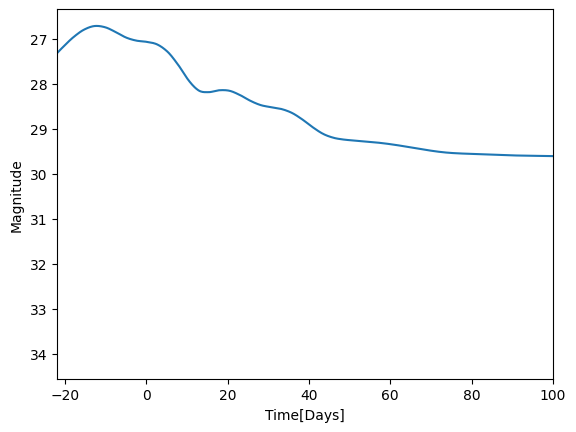

In [77]:
from slsim.image_simulation import lens_image_series
from slsim.Plots.plot_functions import create_image_montage_from_image_list

light_curve = lens_class.source.variability_class.kwargs_model
plt.plot(light_curve["MJD"], light_curve["ps_mag_i"])
plt.gca().invert_yaxis()
plt.ylabel("Magnitude")
plt.xlabel("Time" "[Days]")
plt.xlim(-22, 100)

### Image Configuration and Simulation

In [99]:
time = np.array([-40, -20, -10, -5, 0, 5, 10, 20, 40, 60])

repeats = 10

# Load psf kernel and transform matrix.
path = "/Users/Carly/slsim/tests/TestData/psf_kernels_for_deflector.npy" #......./slsim/tests/Test/Data/psf_kernels_for_deflector.npy
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# Set up psf kernel for each exposure
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats

# Set pixel to angle transform matrix
transform_matrix_all = transform_matrix_list * repeats

# Provide magnitude zero point for each exposure
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats

expo_list = [30]
exposure_time_all = expo_list * repeats

In [104]:
# Simulate a lens image
image_lens_series = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=mag_zero_points_all,
    num_pix=32,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    # Sets extended source and deflector to appear in the lens image
    with_deflector=True,
    with_source=True)

# In log scale:
log_images = []
for i in range(len(image_lens_series)):
    log_images.append(np.log10(image_lens_series[i]))

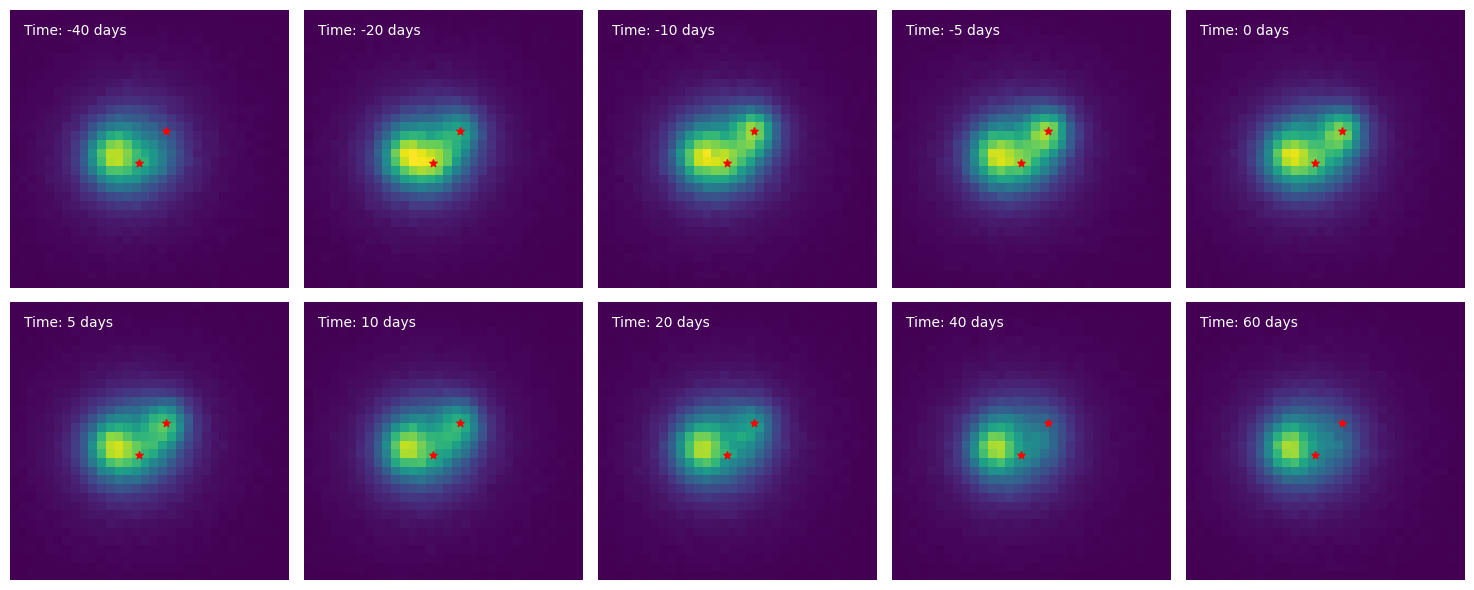

In [105]:
plot_montage = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=image_lens_series, time=time, image_center=pix_coord
)